<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [x] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [x] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

### Load and prep data

In [0]:
!pip install category_encoders
!pip install pdpbox
!pip install eli5

In [0]:
import pandas as pd
from numpy import log1p,expm1
import numpy as np

url = "https://raw.githubusercontent.com/Tclack88/Renewable-Energy/master/power_plants.csv"
data = pd.read_csv(url)
data = data.drop_duplicates()
data['power_encoded'] = log1p(data.total_power)

### split data by renewable energy, fossil fuels and others
Coal plants can be built anywhere, so their latitudes and longitudes shouldn't have strong correlation with power output, but solar and wind for example should

In [163]:
energy_codes

,Unnamed: 0,Fuel Type,Energy,Unit Label,Higher Heating,Unnamed: 5,Energy Source Description
0,NaN,NaN,Source Code,NaN,Value Range,NaN,NaN
1,NaN,NaN,NaN,NaN,MMBtu Lower,MMBtu Upper,NaN
2,NaN,Fossil Fuels,NaN,NaN,NaN,NaN,NaN
3,NaN,Coal,ANT,Tons,22,28,Anthracite Coal
4,NaN,Coal,BIT,Tons,20,29,Bituminous Coal
5,NaN,Coal,LIG,Tons,10,14.5,Lignite Coal
6,NaN,Coal,SGC,Mcf,0.2,0.3,Coal-Derived Synthesis Gas
7,NaN,Coal,SUB,Tons,15,20,Subbituminous Coal
8,NaN,Coal,WC,tons,6.5,16,"Waste/Other Coal (incl. anthracite culm, bitum..."
9,NaN,Coal,RC,tons,20,29,Refined Coal


In [0]:
url2 = "https://www.eia.gov/electricity/data/eia860m/archive/xls/energy_source_codes_prime_mover.xlsx"

energy_codes = pd.read_excel(url2,header=1)

fossil_fuel_table = energy_codes.iloc[3:21]
fossil_fuel_table['Fuel Type'] = fossil_fuel_table['Fuel Type'].ffill()
fossil_fuel_table = fossil_fuel_table.iloc[:,[1,2,6]]

renewable_fuel_table = energy_codes.iloc[22:39]
renewable_fuel_table['Fuel Type'] = renewable_fuel_table['Fuel Type'].ffill()
renewable_fuel_table = renewable_fuel_table.iloc[:,[1,2,6]]


other_fuel_table = energy_codes.iloc[39:]
other_fuel_table['Fuel Type'] = renewable_fuel_table['Fuel Type'].ffill()
other_fuel_table = other_fuel_table.iloc[:,[1,2,6]]
                                                 
                                                 

re_codes = set(renewable_fuel_table.Energy)
ff_codes = set(fossil_fuel_table.Energy)
oth_codes = set(other_fuel_table.Energy)

def return_renewable(x):
  if x in re_codes:
    return x
  else:
    return 'drop'
  
def return_fossil(x):
  if x in ff_codes:
    return x
  else:
    return 'drop'
  
    
def return_other(x):
  if x in oth_codes:
    return x
  else:
    return 'drop'

In [174]:
energy_codes

,Unnamed: 0,Fuel Type,Energy,Unit Label,Higher Heating,Unnamed: 5,Energy Source Description
0,NaN,NaN,Source Code,NaN,Value Range,NaN,NaN
1,NaN,NaN,NaN,NaN,MMBtu Lower,MMBtu Upper,NaN
2,NaN,Fossil Fuels,NaN,NaN,NaN,NaN,NaN
3,NaN,Coal,ANT,Tons,22,28,Anthracite Coal
4,NaN,Coal,BIT,Tons,20,29,Bituminous Coal
5,NaN,Coal,LIG,Tons,10,14.5,Lignite Coal
6,NaN,Coal,SGC,Mcf,0.2,0.3,Coal-Derived Synthesis Gas
7,NaN,Coal,SUB,Tons,15,20,Subbituminous Coal
8,NaN,Coal,WC,tons,6.5,16,"Waste/Other Coal (incl. anthracite culm, bitum..."
9,NaN,Coal,RC,tons,20,29,Refined Coal


In [0]:
energy_codes.Energy = energy_codes.Energy.fillna('OTH') # one NaN is causing trouble

In [0]:
renewables = data[data['energy_source'].apply(return_renewable) != 'drop']
fossil_fuels = data[data['energy_source'].apply(return_fossil) != 'drop']
other = data[data['energy_source'].apply(return_other) != 'drop']

In [0]:
renewable_baselines = renewables.groupby('plant_type').total_power.mean().to_dict() # create dictionary for meanbaseline by tech
fossil_fuel_baselines = fossil_fuels.groupby('plant_type').total_power.mean().to_dict()
other_baselines = other.groupby('plant_type').total_power.mean().to_dict()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# r - renewables
# f - fossil fuels
# 0 - other

features_r = renewables.drop(columns=['total_power','power_encoded'])
target_r = renewables['power_encoded']

features_f = fossil_fuels.drop(columns=['total_power','power_encoded'])
target_f = fossil_fuels['power_encoded']

features_o = other.drop(columns=['total_power','power_encoded'])
target_o = other['power_encoded']

In [0]:
X_train_r,X_test_r,y_train_r,y_test_r = train_test_split(features_r,target_r,random_state=88)
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(features_f,target_f,random_state=88)
X_train_o,X_test_o,y_train_o,y_test_o = train_test_split(features_o,target_o,random_state=88)

### Model Predictions and Partial Dependencies
(using XGBoost for practice because I'm well versed in random forest regressors)

In [0]:
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import mean_absolute_error as mae

In [182]:
xgb_r = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                      XGBRegressor(n_estimators=300,n_jobs=-1,objective='reg:squarederror'))

xgb_r.fit(X_train_r,y_train_r)
r_pred = expm1(xgb_r.predict(X_test_r))
r_baseline = np.array(X_test_r.plant_type.map(renewable_baselines))
print("Renewables Mean Absolute Error with baseline:",mae(y_test_r,r_baseline))
print("Renewables Mean Absolute Error with XBG regressor:",mae(y_test_r,r_pred))

Renewables Mean Absolute Error with baseline: 30.421230670298478
Renewables Mean Absolute Error with XBG regressor: 23.42610934098602


In [183]:
xgb_f = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                      XGBRegressor(n_estimators=300,n_jobs=-1,objective='reg:squarederror'))

xgb_f.fit(X_train_f,y_train_f)
f_pred = expm1(xgb_f.predict(X_test_f))
f_baseline = np.array(X_test_f.plant_type.map(fossil_fuel_baselines))
print("Fossil Fuel Mean Absolute Error with baseline:",mae(y_test_f,f_baseline))
print("Fossil Fuel Mean Absolute Error with XBG regressor:",mae(y_test_f,f_pred))

Fossil Fuel Mean Absolute Error with baseline: 130.2145913296801
Fossil Fuel Mean Absolute Error with XBG regressor: 98.73508700575559


In [184]:
xgb_o = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                      XGBRegressor(n_estimators=300,n_jobs=-1,objective='reg:squarederror'))

xgb_o.fit(X_train_o,y_train_o)
o_pred = expm1(xgb_o.predict(X_test_o))
o_baseline = np.array(X_test_o.plant_type.map(other_baselines))
print("Other fuels Mean Absolute Error with baseline:",mae(y_test_o,o_baseline))
print("Other fuels Mean Absolute Error with XBG regressor:",mae(y_test_o,o_pred))

Other fuels Mean Absolute Error with baseline: 409.2883809318941
Other fuels Mean Absolute Error with XBG regressor: 413.3773886333625


#### Get feature importances

In [0]:
encoder_r = xgb_r.named_steps['onehotencoder'] 
feature_names_r = encoder_r.fit_transform(X_train_r).columns.to_list()

encoder_f = xgb_f.named_steps['onehotencoder'] 
feature_names_f = encoder_f.fit_transform(X_train_f).columns.to_list()

encoder_o = xgb_o.named_steps['onehotencoder'] 
feature_names_o = encoder_o.fit_transform(X_train_o).columns.to_list()

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

In [186]:
model_xgb_r = xgb_r.named_steps['xgbregressor']
model_xgb_f = xgb_f.named_steps['xgbregressor']
model_xgb_o = xgb_o.named_steps['xgbregressor']


permuter_r = PermutationImportance(model_xgb_r,
                                   n_iter = 5,
                                   scoring = 'neg_mean_absolute_error')
permuter_f = PermutationImportance(model_xgb_f,
                                   n_iter = 5,
                                   scoring = 'neg_mean_absolute_error')
permuter_o = PermutationImportance(model_xgb_o,
                                   n_iter=5,
                                   scoring='neg_mean_absolute_error')


X_test_r_enc = encoder_r.transform(X_test_r)
permuter_r.fit(X_test_r_enc,y_test_r)

X_test_f_enc = encoder_f.transform(X_test_f)
permuter_f.fit(X_test_f_enc,y_test_f)

X_test_o_enc = encoder_o.transform(X_test_o)
permuter_o.fit(X_test_o_enc,y_test_o)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=None,
                                             n_estimators=300, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:squarederror',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                

In [187]:
eli5.show_weights(permuter_r,
                  top=None,
                  feature_names = feature_names_r)

Weight,Feature
0.4906 ± 0.0214,n_units
0.2011 ± 0.0069,year_built
0.1406 ± 0.0078,lat
0.1015 ± 0.0086,lon
0.0677 ± 0.0099,prime_mover_ST
0.0637 ± 0.0053,plant_type_Solar Photovoltaic
0.0280 ± 0.0043,prime_mover_IC
0.0154 ± 0.0037,plant_type_Onshore Wind Turbine
0.0133 ± 0.0051,plant_type_Hydroelectric Pumped Storage
0.0114 ± 0.0016,energy_source_SUN


In [188]:
eli5.show_weights(permuter_f,
                  top=None,
                  feature_names = feature_names_f)

Weight,Feature
0.9985 ± 0.0814,prime_mover_IC
0.2220 ± 0.0216,n_units
0.2180 ± 0.0300,year_built
0.0825 ± 0.0064,plant_type_Natural Gas Fired Combined Cycle
0.0822 ± 0.0158,lat
0.0791 ± 0.0052,plant_type_Conventional Steam Coal
0.0691 ± 0.0052,plant_type_Natural Gas Steam Turbine
0.0550 ± 0.0139,plant_type_Other Natural Gas
0.0528 ± 0.0132,lon
0.0179 ± 0.0053,energy_source_DFO


In [189]:
eli5.show_weights(permuter_o,
                  top=None,
                  feature_names = feature_names_o)

Weight,Feature
1.9702 ± 0.4280,plant_type_Nuclear
0.0910 ± 0.0496,year_built
0.0706 ± 0.0292,lon
0.0516 ± 0.0628,lat
0.0409 ± 0.0106,n_units
0.0166 ± 0.0069,energy_source_PUR
0.0097 ± 0.0074,energy_source_WH
0.0094 ± 0.0190,prime_mover_OT
0.0091 ± 0.0183,prime_mover_ST
0.0089 ± 0.0303,plant_type_Batteries


Year Built has at least some significance for each type of energy, let's see more specifically which years are important

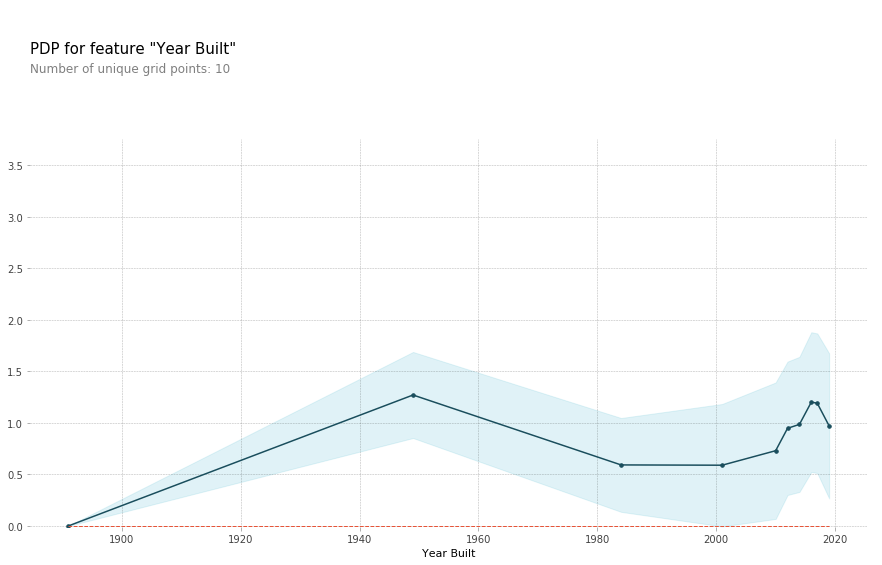

In [190]:
isolated_r = pdp_isolate(model = model_xgb_r,
                         dataset = X_test_r_enc,
                         model_features = feature_names_r,
                         feature = 'year_built')

pdp_plot(isolated_r,feature_name='Year Built');

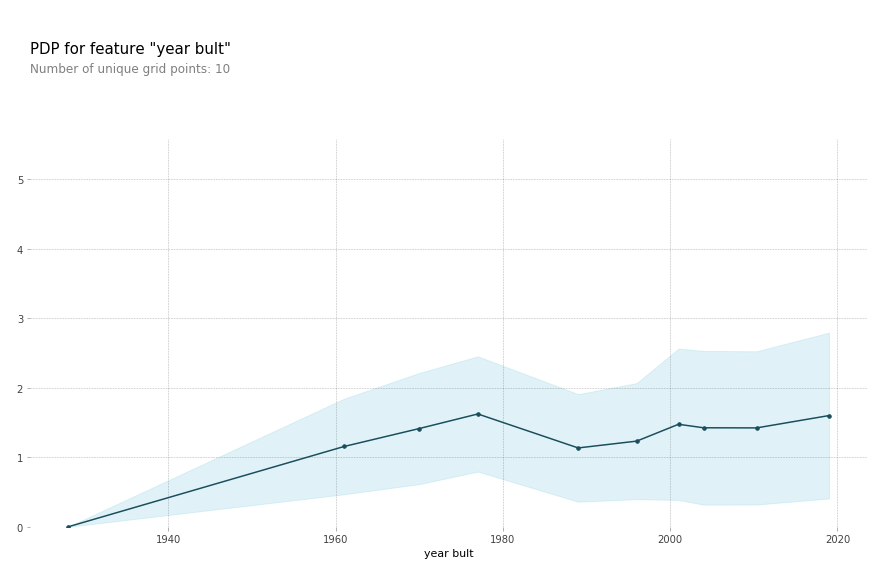

In [191]:
isolated_f = pdp_isolate(model = model_xgb_f,
                         dataset = X_test_f_enc,
                         model_features = feature_names_f,
                         feature = 'year_built')

pdp_plot(isolated_f,feature_name = 'year bult');

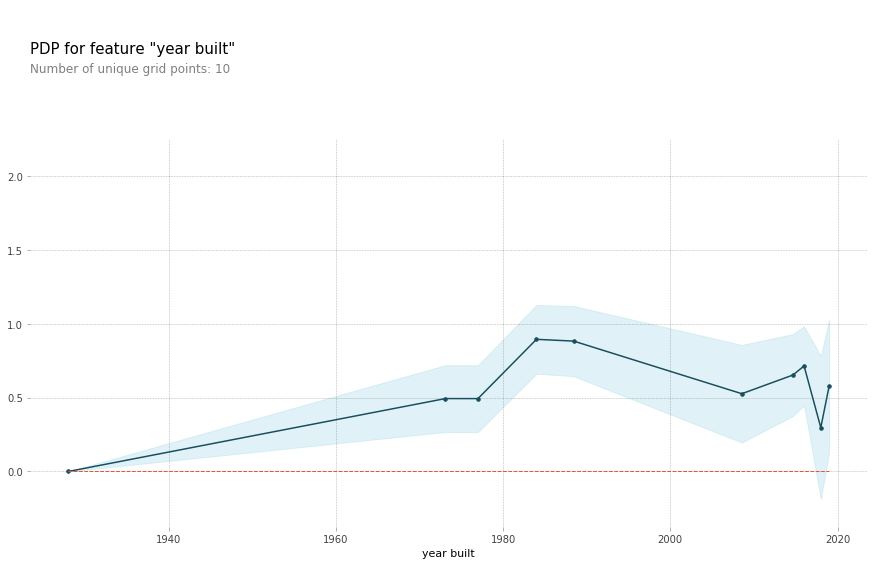

In [192]:
isolated_o = pdp_isolate(model = model_xgb_o,
                         dataset = X_test_o_enc,
                         model_features = feature_names_o,
                         feature = 'year_built')

pdp_plot(isolated_o, feature_name = 'year built');